This jupyter notebook does step-by-step coregisteration (using RHINO) and source-reconstruction for a specified subject/run (using `sub` and `run` variables). 

`sub_run_combo` combines `sub` and `run` variables into e.g., `sub-17_run-2`.

Outputs are contained in:
- `coins-meg_data/derivatives/recon/{sub_run_combo}`
    - `./rhino/coreg` contains two interactive HTML plots to check the coregistration quality. 
- `coins-meg_data/derivatives/src/{sub_run_combo}` (`parc_raw.fif`)

## Import packages, set study data directory

In [286]:
import re
import os
import os.path as op
import osl
from pprint import pprint
from osl import utils
from osl import source_recon
import numpy as np
import coinsmeg_data as coinsmeg
import open3d
from IPython.display import HTML, display

In [287]:
# Directories
preproc_dir = op.join(coinsmeg.DERIVATIVES_DIR, "preprocessed")
recon_dir = op.join(coinsmeg.DERIVATIVES_DIR, "recon")

In [288]:
sub = coinsmeg.sub_num2str(20) #  function sub_num2str converts a numerical subject identifier into a string formatted as sub-XX
run = "run-4"

sub_run_combo = f"{sub}_{run}"
# Directories
preproc_dir = op.join(coinsmeg.DERIVATIVES_DIR, "preprocessed")
recon_dir = op.join(coinsmeg.DERIVATIVES_DIR, "recon")

print(preproc_dir)
print(sub_run_combo)


/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed
sub-20_run-4


In [289]:
anat_dir = coinsmeg.get_sub_anat_dir(sub)
smri_file = f"{anat_dir}/{sub}_T1w.nii"

print('Structural files:')
pprint(smri_file)

Structural files:
'/ohba/pi/lhunt/datasets/coins-meg_data/sub-20/ses-3-structural/anat/sub-20_T1w.nii'


In [290]:
study = osl.utils.Study(f'{preproc_dir}/{{subject_id}}_ses-2-meg_task-coinsmeg_{{run_id}}_meg_transsss/{{subject_id}}_ses-2-meg_task-coinsmeg_{{run_id}}_meg_transsss_preproc_raw.fif')
all_files = study.get()
fif_file = study.get(subject_id=sub, run_id=run) 
fif_file = fif_file[0] # as fif_file initially a list
print(fif_file)

found 78 files
keeping 78 consistent files
/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif


## Compute Surfaces, Coregistration and Forward Modelling

### Compute surfaces

The first thing we need to do is to use the structural image to compute the head and brain surfaces in Native and MNI space using *rhino.compute_surfaces*. The head and brain surfaces will be used later  for carrying out the coregistration and forward modelling.

For now, we'll do this for one subject.

The inputs we need to provide are for the first subject are:

* *smri_file* - the full path to the structural MRI niftii file
* *recon_dir* - the full path to the directory that will contain the subject directories that RHINO will output
* *subject* - the name of the subject directory that RHINO will output
* *include_nose* - a boolean flag indicating whether or not to extract a head surface from the structural MRI that includes the nose. It your structural MRI includes the nose AND you have acquired polhemus headshape points that include the nose, then it is recommend to set this flag to True

In [291]:
source_recon.rhino.compute_surfaces(
    smri_file,
    recon_dir,
    sub_run_combo,
    include_nose=True,
)

*** RUNNING OSL RHINO COMPUTE SURFACES ***
The nose is going to be added to the outer skin (scalp) surface.
Please ensure that the structural MRI has a FOV that includes the nose
reorienting subject brain to be RADIOLOGICAL
You can use the following call to check the passed in structural MRI is appropriate,
including checking that the L-R, S-I, A-P labels are sensible:
In Python:
fsleyes("/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/surfaces/smri.nii.gz", "/home/ali/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz")
From the cmd line:
fsleyes /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/surfaces/smri.nii.gz /home/ali/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz
Running BET pre-FLIRT...
Running FLIRT...
Running BET and BETSURF...
Refining scalp surface...
Adding nose to scalp surface...
rhino.surfaces.surfaces_display("/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon", "sub-20_run-4") can be used to check the result
*** O

False

We can now view the result using *fsleyes*. Note that *fsleyes* can sometimes take a few moments to open.

CHECK: in fsleyes that:

* The surfaces have been extracted properly compared with the structural
* The nose is included in the scalp surface, if that was requested with the *include_nose* option above

In [292]:
#source_recon.rhino.surfaces_display(recon_dir, sub_run_combo)

### Get Polhemus-space coordinates

We need to now provide the coordinates for the nasion, LPA, RPA, and headshape points in Polhemus (head) space, in millimetres. The polhemus coordinates need to be extracted from the MEG fif file; it is stored in the info['dig'] attribute of an MNE Raw object.

In [293]:
import mne

raw = mne.io.read_raw_fif(fif_file, preload=False) # fif file from specified subject/run
# Access the digitization data (Polhemus data)
dig = raw.info['dig'] 

Opening raw data file /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif...
    Range : 70000 ... 844999 =     70.000 ...   844.999 secs
Ready.


In [294]:
polhemus_dir = op.join(recon_dir, sub_run_combo, "polhemus")

# make directory if it doesn't yet exist
os.makedirs(polhemus_dir, exist_ok=True)

In [295]:
from osl.source_recon.rhino.polhemus import extract_polhemus_from_info

extract_polhemus_from_info(
    fif_file = fif_file,
    headshape_outfile=op.join(polhemus_dir, "polhemus_headshape.txt"),
    nasion_outfile=op.join(polhemus_dir, "polhemus_nasion.txt"),
    rpa_outfile=op.join(polhemus_dir, "polhemus_rpa.txt"),
    lpa_outfile=op.join(polhemus_dir, "polhemus_lpa.txt")
)

# recall that our maxfiltering options were
# f"--maxpath /neuro/bin/util/maxfilter --mode multistage --scanner Neo --tsss --headpos --movecomp --trans {trans_file}",)
        #  the maxfilter aligns all runs of a participant so that the head position is the same within each participant


Extracting polhemus from fif info
saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/polhemus/polhemus_nasion.txt
saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/polhemus/polhemus_rpa.txt
saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/polhemus/polhemus_lpa.txt
saved: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/polhemus/polhemus_headshape.txt


### Run the coregistration

Now run the coreg! 

But first the `coreg()` function needs e.g., `polhemus_headshape.txt` to be in the `derivatives/recon/sub-17_run-2/rhino/coreg/` folder, so we copy this over from the `derivatives/recon/sub-17_run-2/polhemus/` folder where they currently are...

In [296]:
def copy_polhemus_files(recon_dir, subject, preproc_file, smri_file, logger):
    polhemus_headshape = np.loadtxt(op.join(polhemus_dir, 'polhemus_headshape.txt'))
    polhemus_nasion = np.loadtxt(op.join(polhemus_dir, 'polhemus_nasion.txt'))
    polhemus_rpa = np.loadtxt(op.join(polhemus_dir, 'polhemus_rpa.txt'))
    polhemus_lpa = np.loadtxt(op.join(polhemus_dir, 'polhemus_lpa.txt'))
    
    #  Get coreg filenames
    filenames = source_recon.rhino.get_coreg_filenames(recon_dir, subject)

    # Save
    np.savetxt(filenames["polhemus_nasion_file"], polhemus_nasion)
    np.savetxt(filenames["polhemus_rpa_file"], polhemus_rpa)
    np.savetxt(filenames["polhemus_lpa_file"], polhemus_lpa)
    np.savetxt(filenames["polhemus_headshape_file"], polhemus_headshape)

copy_polhemus_files(recon_dir, sub_run_combo, [], [], [])

In [297]:
# Then we run the coreg, for real.

source_recon.rhino.coreg(
    fif_file, # full path to the MNE raw fif file
    recon_dir, # full path to the directory that contains the subject directories RHINO outputs
    sub_run_combo, # the name of the subject directories RHINO outputs to
    use_headshape=True,     #use the headshape points to refine the coregistration?
    use_nose=True, # use the nose headshape points to refine the coregistration?
)

*** RUNNING OSL RHINO COREGISTRATION ***
Opening raw data file /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif...
    Range : 70000 ... 844999 =     70.000 ...   844.999 secs
Ready.
Creating RawArray with float64 data, n_channels=331, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Writing /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/info-raw.fif
Closing /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/info-raw.fif
[done]
The MRI-derived nose is going to be used to aid coreg.
Please ensure that rhino.compute_surfaces was run with include_nose=True.
Please ensure that the polhemus headshape points include the nose.
loading: /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/polhemus_headshape.txt
loading: /ohba/pi/lhunt/datasets/coins-me

In [298]:
# now view result
source_recon.rhino.coreg_display(subjects_dir = "/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon", 
                                 subject = sub_run_combo,
                                 filename = f"{recon_dir}/{sub_run_combo}/rhino/coreg/coreg_display_plot.html") # saves an interactive html plot at this location

Creating surface mesh for /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/scaled_outskin_plus_nose_mesh.nii.gz .....
saving /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/coreg_display_plot.html


The above coregistration result displays the coregistered RHINO scalp surface and polhemus/sensor locations.

Display is done in MEG (device) space (in mm).is shown in MEG (device) space (in mm).

* Grey disks - MEG sensors
* Blue arrows - MEG sensor orientations
* Yellow diamonds - MRI-derived fiducial locations
* Pink spheres - Polhemus-derived fiducial locations
* Green surface - Whole head scalp extraction
* Red spheres - Polhemus-derived headshape points

A good coregistration shows:

* MRI fiducials (yellow diamonds) in appropriate positions on the scalp
* Polhemus-derived fiducial locations (pink spheres) in appropriate positions on the scalp 
* Good correspondence between the headshape points (red spheres) and the scalp
* The scalp appropriately inside the sensors, and with a sensible orientation.

If you have a bad co-registration:

* Go back and check that the compute_surfaces has worked well using fsleyes (see above).
* Check for misleading or erroneous headshape points (red spheres) and remove them. See the <a href="https://osf.io/nr9su" target="_top">Deleting Headshape Points</a> tutorial for how to delete headshape points.

* Check that the settings for using the nose are compatible with the available MRI and headshape points
* The subject in question may need to be omitted from the ensuing analysis.

### Compute forward model

We can now compute the forward model (the lead fields) given we can now put the MEG sensors and head / brain surfaces in the same coordinate system. We do this by running *rhino.forward_model*. Note that this is mostly just a wrapper call for a standard MNE function.

Here we are modelling the brain/head using 'Single Layer', which corresponds to just modelling the inner skull surface, which is the standard thing to do in MEG forward modelling.

Lead fields will be computed for a regularly space dipole grid, with a spacing given by the passed in argument *gridstep*. The dipole grid is confined to be inside the brain mask as computed by *rhino.compute_surfaces*.

In [299]:
gridstep = 10
source_recon.rhino.forward_model(
    recon_dir,
    sub_run_combo,
    model="Single Layer",
    gridstep=gridstep,
)

*** RUNNING OSL RHINO FORWARD MODEL ***
Using bet_inskull_surf_file for single shell surface
Surface CM = (   0.5   -3.8  -14.6) mm
Surface fits inside a sphere with radius   93.9 mm
Surface extent:
    x =  -71.0 ...   70.9 mm
    y =  -82.9 ...   85.0 mm
    z =  -87.9 ...   52.9 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y =  -90.0 ...   90.0 mm
    z =  -90.0 ...   60.0 mm
5168 sources before omitting any.
3324 sources after omitting infeasible sources not within 0.0 - 93.9 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 3324 points...
    Found  267/3324 points inside  an interior sphere of radius   39.9 mm
    Found    0/3324 points outside an exterior sphere of radius   93.9 mm
    Found 1571/3057 points outside using surface Qhull
    Found  103/1486 points outside using solid angles
    Total 1650/3324 points inside the surface
Interior check c

Now view the results. The following the coregistered RHINO scalp surface and inner skull surface. Display is done in MEG (device) space (in mm).

Note that small black points inside the brain show the locations of dipoles that the leadfields have been computed for.

In [300]:
source_recon.rhino.bem_display(
    recon_dir,
    sub_run_combo,
    display_outskin_with_nose=False,
    display_sensors=True,
    plot_type="surf",
    filename=f"{recon_dir}/{sub_run_combo}/rhino/coreg/bem_display_plot.html",
)

Reading forward solution from /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (1392 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
BEM surface: number of dipoles = 1392


/home/ali/anaconda3/envs/osl/lib/python3.8/site-packages/pyvista/plotting/renderer.py:536: UserWarning: VTK compiled with OSMesa does not properly support FXAA anti-aliasing and SSAA will be used instead.
  warnings.warn(


Overwriting existing file.
saving /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/coreg/bem_display_plot.html


In [301]:
# Display HTML content in notebook
display(HTML(f"{recon_dir}/{sub_run_combo}/rhino/coreg/bem_display_plot.html"))

We now have a *forward_model_file* stored in the rhino directory for this subject.
    
This file contains the leadfields that map from source to sensor space, and which are used to do source reconstruction.


In [302]:
from mne import read_forward_solution

# load forward solution
fwd_fname = op.join(recon_dir, sub_run_combo, "rhino", "model-fwd.fif") 
# tutorial said source_recon.rhino.get_coreg_filenames(recon_dir, subjects[0])["forward_model_file"]
# but this did not return a match for "forward_model_file"
print(fwd_fname)

/ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/model-fwd.fif


In [303]:
fwd = read_forward_solution(fwd_fname)
leadfield = fwd["sol"]["data"]
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Reading forward solution from /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (1392 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Leadfield size : 306 sensors x 4176 dipoles


## Temporal Filtering

We temporally filter the data to focus on the oscillatory content that we are interest in. 

Here, we assume that we will be doing an evoked response (ERF) analysis on the epoched task data, and so we filter to the frequency range where the evoked response is typically contained, i.e. between 1 and 30 Hz.


In [304]:
import mne

chantypes = ["grad", "mag"] 

# Get and setup the data
data = mne.io.read_raw_fif(fif_file, preload=True)
data = data.pick(chantypes)

# Filter to the beta band
print("Temporal Filtering")
data = data.filter(
    l_freq=1,
    h_freq=30,
    method="iir",
    iir_params={"order": 5, "btype": "bandpass", "ftype": "butter"},
)
print("Completed")

Opening raw data file /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif...
    Range : 70000 ... 844999 =     70.000 ...   844.999 secs
Ready.
Reading 0 ... 774999  =      0.000 ...   774.999 secs...
Temporal Filtering
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Completed


In [305]:
data.pick(chantypes)

<Raw | sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif, 306 x 775000 (775.0 s), ~1.77 GB, data loaded>

## Compute beamformer weights

We now compute the beamformer weights (aka filters). These are computed using the (sensors x sensors) data covariance matrix estimated from the preprocessed and the temporally filtered MEG data (contained in *raw*), and the forward models (contained inside the subject's folder inside the directory *recon_dir*. 

Note that this automatically ignores any bad time segments when calculating the beamformer filters.

Here we are source reconstructing using just the gradiometers.

The MEG data has been maxfiltered and so the maximum rank is ~64. We therefore slightly conservatively set the rank to be 55. **This is used to regularise the estimate of the data covariance matrix.**

More generally, a dipole is a 3D vector in space. Setting *pick_ori="max-power-pre-weight-norm"* means that we are computing a scalar beamformer, by projecting this 3D vector on the direction in which there is maximum power. 

In [306]:
from osl.source_recon import rhino, beamforming, parcellation
      
# Make LCMV beamformer filters
# Note that this will exclude any bad time segments when calculating the beamformer filters
filters = beamforming.make_lcmv(
    recon_dir,
    sub_run_combo,
    data,
    chantypes,
    pick_ori="max-power-pre-weight-norm",
    rank={"meg": 60},
)

*** RUNNING OSL MAKE LCMV ***
Reading forward solution from /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (1392 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 3875 segments
Number of samples used : 683600
[done]
variance for chantype grad is 2.7525480018024586e-23
variance for chantype mag is 6.836199666422474e-26
Computing rank from covariance with rank={'meg': 60}
Computing rank from covariance with rank='info'
    MEG: rank 306 after 0 projectors applied to 306 channels
Making LCMV beamformer with data cov rank {'meg': 60}
Making LCMV beamformer with noise cov rank {'meg': 306}
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Whitening the forward

## Apply beamformer weights

We now apply the beamformer filters to the data to project the data into source space.

Note that although the beamformer filters were calculated by ignoring any bad time segments, we apply the filters to all time points including the bad time segments. This will make it easier to do epoching later.

In [307]:
print("Applying beamformer spatial filters")

# stc is source space time series (in head/polhemus space).
stc = beamforming.apply_lcmv(data, filters)

# Convert from head/polhemus space to standard brain grid in MNI space
recon_timeseries_mni, reference_brain_fname, recon_coords_mni, _ = \
        beamforming.transform_recon_timeseries(recon_dir, 
                                                sub_run_combo, 
                                                recon_timeseries=stc.data, 
                                                reference_brain="mni")

print("Completed")
print("Dimensions of reconstructed timeseries in MNI space is (dipoles x all_tpts) = {}".format(recon_timeseries_mni.shape))

Applying beamformer spatial filters
beamforming.apply_lcmv
Omitting 61398 of 775000 (7.92%) samples, retaining 713602 (92.08%) samples.
Reading forward solution from /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/recon/sub-20_run-4/rhino/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (1392 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 10 mm
Completed
Dimensions of reconstructed timeseries in MNI space is (dipoles x all_tpts) = (2527, 713602)


## Parcellation

At this point, the data has been source reconstructed to dipoles (in this case, a scalar value) at each point on a regular 3D grid, with spacings of 10mm. We could then analyse the data across all these dipoles.

An alternative, is to map the data onto a brain parcellation. This reduces the number of samples in the space from number of dipoles down to number of parcels. Using a parcellation helps to boost the signal to noise ratio, boost correspondance between subjects, reduce the severity of multiple comparison correction when doing any statistics, and aids anatomical interpretability.

The parcellation we use here is a combination of cortical regions from the Harvard Oxford atlas, and selected sub-cortical regions from the Schaefer 100 parcellation. 

Let's take a look at the positions of the centres of each parcel in the parcellation.

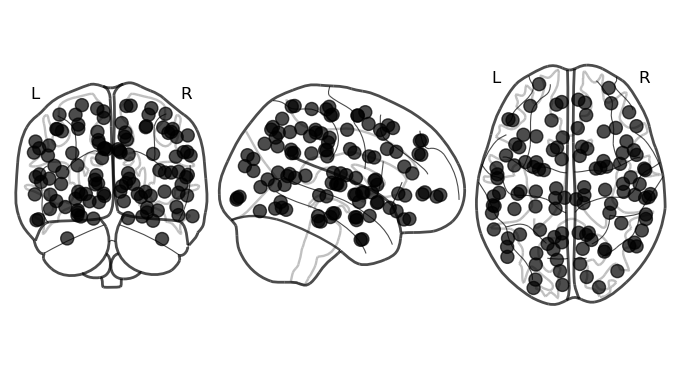

In [308]:
parcellation_fname = 'HarvOxf-sub-Schaefer100-combined-2mm_4d_ds8.nii.gz'

# plot centre of mass for each parcel
p = parcellation.plot_parcellation(parcellation_fname)

### Compute Parcel Time-courses

We use this parcellation to compute the parcel time courses using the parcellation and the dipole time courses. Note that the output parcel timepoints includes all time points, including any bad time segments.

Let's now parcellate the data to compute parcel time courses. This is done using the "spatial_basis" method, where the parcel time-course 
first principal component from all voxels, weighted by the spatial map for the parcel.

In [309]:
print("Parcellating data")

# Apply parcellation to (voxels x all_tpts) data contained in recon_timeseries_mni.
# The resulting parcel_timeseries will be (parcels x all_tpts) in MNI space
# where all_tpts includes bad time segments
parcel_ts, _, _ = parcellation.parcellate_timeseries(
    parcellation_fname, # corresponds to the -beamform_and_parcellate: method: parcellation_file
    recon_timeseries_mni, # reconstructed timeseries in MNI space; dimensions are (dipoles x all_tpts)
    recon_coords_mni,  # dimensions are 3 x dipoles ((3, 2527)). the 3 rows are x, y, and z coordinates in MNI space
    "spatial_basis",  # corresponds to the -beamform_and_parcellate: method: setting
    recon_dir,
)

print("Completed")
print("Dimensions of parcel timeseries in MNI space is (nparcels x all_tpts) = {}".format(parcel_ts.shape))

Parcellating data
gridstep = 10 mm


Completed
Dimensions of parcel timeseries in MNI space is (nparcels x all_tpts) = (114, 713602)


Now put parcel time courses into a new MNE raw object `parc_raw`, so that working with the data later in MNE is easier.

In [310]:
# Create mne raw object for the parcellated data

# We reload raw data to ensure that the stim channel is in there
raw = mne.io.read_raw_fif(fif_file) # recall that fif_file is a specific subject/run

parc_raw = parcellation.convert2mne_raw(parcel_ts, raw)

print("Dimensions of parc_raw are (nparcels x all_tpts) = {}".format(parc_raw.get_data().shape))

Opening raw data file /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss/sub-20_ses-2-meg_task-coinsmeg_run-4_meg_transsss_preproc_raw.fif...
    Range : 70000 ... 844999 =     70.000 ...   844.999 secs
Ready.
Omitting 61398 of 775000 (7.92%) samples, retaining 713602 (92.08%) samples.
Creating RawArray with float64 data, n_channels=114, n_times=775000
    Range : 0 ... 774999 =      0.000 ...   774.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=775000
    Range : 0 ... 774999 =      0.000 ...   774.999 secs
Ready.
Dimensions of parc_raw are (nparcels x all_tpts) = (115, 775000)


In [311]:
# source space data directory
src_dir = op.join(coinsmeg.DERIVATIVES_DIR, "src", sub_run_combo) # directory for saving source reconstructed files
os.makedirs(src_dir, exist_ok=True)

# save parc_raw into the src_dir
parc_raw.save(op.join(src_dir, "parc_raw.fif"), overwrite=True)

Writing /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/src/sub-20_run-4/parc_raw.fif
Closing /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/src/sub-20_run-4/parc_raw.fif
[done]


# Epoching

In [201]:
from osl import preprocessing

dataset = preprocessing.read_dataset(fif_file, ftype = "preproc_raw") 
# ftype shows the ending that was replaced by event-id, events, etc
# default was preproc-raw
dataset

Loading dataset:
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_events.npy
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_event-id.yml
Reading /ohba/pi/lhunt/datasets/coins-meg_data/derivatives/preprocessed/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss/sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_ica.fif


{'raw': <Raw | sub-17_ses-2-meg_task-coinsmeg_run-1_meg_transsss_preproc_raw.fif, 331 x 858000 (858.0 s), ~6.5 MB, data not loaded>,
 'events': array([[ 181696,       4,     100],
        [ 186664,       0,     101],
        [ 204240,       0,     102],
        ...,
        [ 999762,       0,       4],
        [1000230,       0,      20],
        [1008966,       0,     105]]),
 'event_id': {'blockEnd': 20,
  'blockStart': 10,
  'expEnd': 105,
  'expStart': 100,
  'keyDown': 6,
  'keyLeft': 4,
  'keyRelease': 7,
  'keyRight': 3,
  'keyUp': 5,
  'laserHit': 1,
  'laserMiss': 2},
 'epochs': None,
 'ica': <ICA | raw data decomposition, method: fastica (fit in 80 iterations on 812300 samples), 64 ICA components (306 PCA components available), channel types: mag, grad, 2 sources marked for exclusion>}

In [202]:
epochs = mne.Epochs(
    parc_raw,
    dataset["events"],
    dataset["event_id"],
    tmin=-0.5,
    tmax=1,
    baseline= (0, 0.3),
)

print("Dimensions of epochs are (good_epochs x parcels x tpts_within_epoch) = {}".format(epochs.get_data().shape))


Dimensions of epochs are (good_epochs x parcels x tpts_within_epoch) = (4917, 115, 1501)


Now plot a simple evoked response for this session of data (averaging over ALL epochs) for a selected parcel.

Plotting group COPE time course for parcel: 2


Text(0, 0.5, 'ERF')

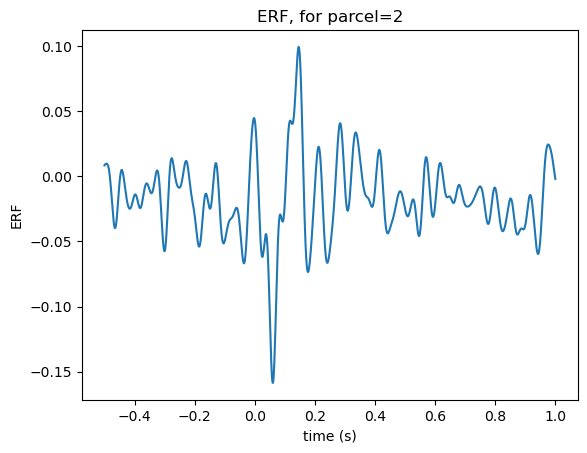

In [203]:
import matplotlib.pyplot as plt
import numpy as np

parcel_ind = 2
print("Plotting group COPE time course for parcel:", parcel_ind)

# average over trials/epochs
erf = np.mean(epochs.get_data()[:, parcel_ind, :], axis=0)

plt.figure()
plt.plot(epochs.times, erf)
plt.title("ERF, for parcel={}".format(parcel_ind))
plt.xlabel("time (s)")
plt.ylabel("ERF")

In [204]:
hit_epochs = epochs["laserHit"]
miss_epochs = epochs["laserMiss"]

In [205]:
hit_epochs

<Epochs |  839 events (all good), -0.5 - 1 sec, baseline 0 – 0.3 sec, ~113 kB, data not loaded,
 'laserHit': 839>

In [206]:
print(hit_epochs.info['ch_names'])

['parcel_0', 'parcel_1', 'parcel_2', 'parcel_3', 'parcel_4', 'parcel_5', 'parcel_6', 'parcel_7', 'parcel_8', 'parcel_9', 'parcel_10', 'parcel_11', 'parcel_12', 'parcel_13', 'parcel_14', 'parcel_15', 'parcel_16', 'parcel_17', 'parcel_18', 'parcel_19', 'parcel_20', 'parcel_21', 'parcel_22', 'parcel_23', 'parcel_24', 'parcel_25', 'parcel_26', 'parcel_27', 'parcel_28', 'parcel_29', 'parcel_30', 'parcel_31', 'parcel_32', 'parcel_33', 'parcel_34', 'parcel_35', 'parcel_36', 'parcel_37', 'parcel_38', 'parcel_39', 'parcel_40', 'parcel_41', 'parcel_42', 'parcel_43', 'parcel_44', 'parcel_45', 'parcel_46', 'parcel_47', 'parcel_48', 'parcel_49', 'parcel_50', 'parcel_51', 'parcel_52', 'parcel_53', 'parcel_54', 'parcel_55', 'parcel_56', 'parcel_57', 'parcel_58', 'parcel_59', 'parcel_60', 'parcel_61', 'parcel_62', 'parcel_63', 'parcel_64', 'parcel_65', 'parcel_66', 'parcel_67', 'parcel_68', 'parcel_69', 'parcel_70', 'parcel_71', 'parcel_72', 'parcel_73', 'parcel_74', 'parcel_75', 'parcel_76', 'parcel_

In [207]:
evoked_hit = hit_epochs.average(picks = parcel_ind)
evoked_hit

<Evoked | 'laserHit' (average, N=839), -0.5 – 1 sec, baseline 0 – 0.3 sec, 1 ch, ~19 kB>

In [208]:
evoked_miss = miss_epochs.average(picks = parcel_ind)
evoked_miss

<Evoked | 'laserMiss' (average, N=291), -0.5 – 1 sec, baseline 0 – 0.3 sec, 1 ch, ~19 kB>

In [209]:
print(evoked_hit.info)

<Info | 9 non-empty values
 bads: []
 ch_names: parcel_2
 chs: 1 misc
 custom_ref_applied: False
 description: TRIUX system at OHBA-3143 OSL BATCH PROCESSING APPLIED ON ...
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-05-12 09:56:56 UTC
 nchan: 1
 projs: []
 sfreq: 1000.0 Hz
>


/tmp/ipykernel_415010/546323318.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks="parcel_2",


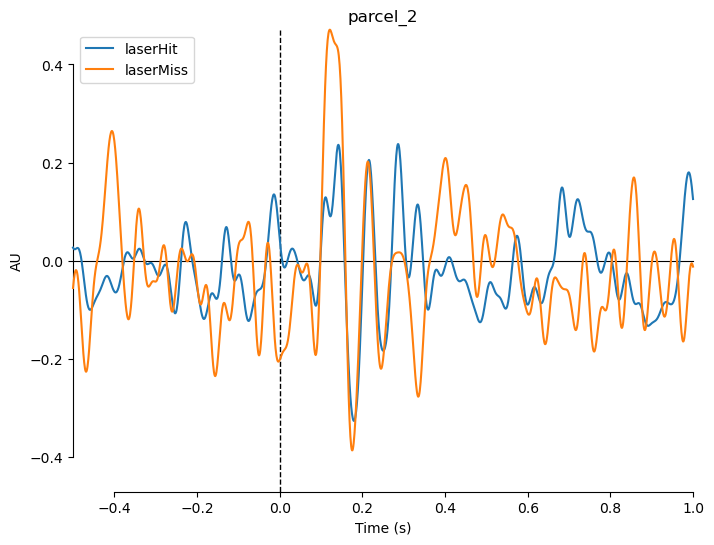

[<Figure size 800x600 with 1 Axes>]

In [210]:
## Compare hit vs miss evokeds, global field power

mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks="parcel_2",
                             show_sensors='upper right')